In [1]:
import pandas as pd
import numpy as np
import glob
import json
import os
import matplotlib.pyplot as plt

/Users/mingbin/anaconda3/envs/gpu_env/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seq_files = glob.glob("../data/whow_sequences/*.csv")
seq_dfs = [pd.read_csv(f) for f in seq_files]
seq_dfs = [df for df in seq_dfs if len(df) > 100]

In [3]:
seq_dfs[0]

,corpus_id,conv_id,utterance_id,utt_index,role,text,info,novo,relv,imsc,info_mtv,social_mtv,coord_mtv,prob,conf,inst,intp,supp,util
0,fora,2733,EGI_Conversations_196_2733_16,15,participant,I can start. I live in a house across the stre...,4,4,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fora,2733,EGI_Conversations_196_2733_17,16,moderator,And what steps have you taken to try to solve ...,2,1,4,1,True,False,False,True,False,False,False,False,False
2,fora,2733,EGI_Conversations_196_2733_18,17,participant,Neighbors organized around the traffic issue t...,4,4,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fora,2733,EGI_Conversations_196_2733_19,18,moderator,[inaudible]. Yeah?,1,1,2,1,False,False,True,False,False,False,False,False,True
4,fora,2733,EGI_Conversations_196_2733_20,19,participant,Did you want a gun or-,2,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,fora,2733,EGI_Conversations_196_2733_214,213,participant,That's Morehead again.,1,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,fora,2733,EGI_Conversations_196_2733_215,214,moderator,"So, they even have a bus stop right there. But...",1,1,2,1,True,False,True,True,False,False,False,True,False
200,fora,2733,EGI_Conversations_196_2733_216,215,participant,"Okay. I mean, I'm mindful of time, I think we ...",1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,fora,2733,EGI_Conversations_196_2733_217,216,moderator,Okay.,1,1,1,1,False,False,True,False,False,False,False,False,True


In [4]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

In [5]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind
from statsmodels.api import OLS, add_constant
from statsmodels.stats.sandwich_covariance import cov_cluster

import pandas as pd
import numpy as np

def stack_episodes(dfs, episode_ids=None, infer_conv_from='utterance_id'):
    """
    Combine multiple episode-level DataFrames into a single conversation-level DataFrame.

    Parameters
    ----------
    dfs : List[pd.DataFrame] or Dict[str, pd.DataFrame]
        Each df is one episode (one conversation).
        If a dict, keys are used as conv_ids automatically.
    episode_ids : Optional[List[str]]
        Explicit conv_id for each df in `dfs` (ignored if `dfs` is a dict).
        If None, we will try:
          1) existing 'conv_id' column if present and single-valued per df;
          2) infer from `infer_conv_from` by dropping the last underscore token;
          3) fall back to epi_001, epi_002, ...
    infer_conv_from : str
        Column name to infer conv_id from (default 'utterance_id') by removing the last "_token".

    Returns
    -------
    pd.DataFrame
        Combined DataFrame with a valid 'conv_id' column and aligned columns.
    """
    # Accept dict input
    if isinstance(dfs, dict):
        episode_ids = list(dfs.keys())
        dfs = list(dfs.values())
    else:
        episode_ids = episode_ids or [None]*len(dfs)

    # ---- 1) unified schema (union of all columns) ----
    all_cols = set()
    for d in dfs:
        all_cols |= set(d.columns)
    all_cols = list(all_cols)

    combined = []
    auto_id_counter = 1

    for i, d in enumerate(dfs):
        df = d.copy()

        # Align schema
        for c in all_cols:
            if c not in df.columns:
                df[c] = np.nan
        df = df[all_cols]

        # ---- 2) ensure conv_id ----
        conv_id = episode_ids[i]
        if conv_id is None:
            if 'conv_id' in df.columns and df['conv_id'].notna().any():
                # use existing if single-valued, else coerce to single value
                uniq = df['conv_id'].dropna().unique()
                conv_id = str(uniq[0]) if len(uniq) >= 1 else None

        if conv_id is None and infer_conv_from in df.columns:
            # try to infer from utterance_id like "EGI_..._2733_16" -> drop last token
            def _infer(u):
                s = str(u).split('_')
                return '_'.join(s[:-1]) if len(s) > 1 else None
            inferred = df[infer_conv_from].dropna().map(_infer)
            conv_id = inferred.mode().iloc[0] if not inferred.dropna().empty else None

        if conv_id is None:
            conv_id = f"epi_{auto_id_counter:03d}"
            auto_id_counter += 1

        df['conv_id'] = conv_id

        # ---- 3) normalize types for key analysis cols if present ----
        # turn index
        if 'utt_index' in df.columns:
            df['utt_index'] = pd.to_numeric(df['utt_index'], errors='coerce')
        # role/text
        if 'role' in df.columns:
            df['role'] = df['role'].astype(str)
        if 'text' in df.columns:
            df['text'] = df['text'].astype(str)

        # outcomes
        for c in ['info','novo','relv','imsc']:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce')

        # moderator binary labels → {0,1} floats
        act_cols  = [c for c in ['prob','conf','inst','intp','supp','util'] if c in df.columns]
        mtv_cols  = [c for c in ['info_mtv','social_mtv','coord_mtv'] if c in df.columns]
        for c in act_cols + mtv_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0.0).clip(0,1)

        combined.append(df)

    # ---- 4) concat and sort ----
    out = pd.concat(combined, ignore_index=True)

    # optional: ensure unique utterance_id
    if 'utterance_id' in out.columns:
        dup = out['utterance_id'].duplicated(keep=False)
        if dup.any():
            # append conv_id to duplicates to make unique but traceable
            out.loc[dup, 'utterance_id'] = (
                out.loc[dup, 'utterance_id'].astype(str) + '::' + out.loc[dup, 'conv_id'].astype(str)
            )

    # sort by conv_id then utt_index if available
    sort_cols = ['conv_id'] + (['utt_index'] if 'utt_index' in out.columns else [])
    out = out.sort_values(sort_cols, kind='mergesort').reset_index(drop=True)

    return out


# ---- Parse conv_id & utt_index from utterance_id ----
def extract_ids(df):
    if 'utt_index' not in df.columns or df['utt_index'].isna().any():
        # infer utt_index from utterance_id suffix
        def _idx(u):
            t = str(u).split('_')[-1]
            return pd.to_numeric(t, errors='coerce')
        df['utt_index'] = df['utterance_id'].apply(_idx)
    # conv_id = utterance_id without the last underscore token
    df['conv_id'] = df['utterance_id'].apply(lambda u: '_'.join(str(u).split('_')[:-1]))
    return df

# ---- Normalize roles & booleans ----
ACT_COLS = ['prob','conf','inst','intp','supp','util']
MTV_COLS = ['info_mtv','social_mtv','coord_mtv']

def normalize(df):
    # role
    df['role_norm'] = df['role'].str.lower().str.strip()
    df['is_mod'] = df['role_norm'].isin(['mod','moderator']).astype(int)
    # text length control
    df['text_len'] = df['text'].fillna('').str.len()
    # cast labels to 0/1 for moderators, 0 for NaN on participants
    for c in ACT_COLS + MTV_COLS:
        df[c] = df[c].astype('float')  # True/False/NaN -> 1.0/0.0/NaN
        df.loc[df['is_mod']==0, c] = 0.0
        df[c] = df[c].fillna(0.0)
    return df

# ---- Convenience: standard error of the mean ----
def sem(x):
    x = pd.to_numeric(x, errors='coerce').dropna()
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x)>1 else np.nan

In [6]:
ACT_ALL = ['prob','conf','inst','intp','supp','util']
MTV_ALL = ['info_mtv','social_mtv','coord_mtv']

def _ensure_combined(all_dfs, stacker=None):
    """
    Return a single DataFrame from either:
      - a DataFrame (returned as-is),
      - a list/dict of DataFrames (stack via `stacker`).
    """
    import pandas as pd
    if isinstance(all_dfs, pd.DataFrame):
        return all_dfs
    if stacker is None:
        raise ValueError("Pass `stacker` (e.g., stack_episodes) when using list/dict of dfs.")
    return stacker(all_dfs)

def build_adjacency_asof(
    all_dfs,
    moderator_roles=('moderator','mod','chair','host','facilitator','mc'),
    acts=True,
    motives=True,
    stacker=None  # pass your stack_episodes if all_dfs is list/dict
):
    import pandas as pd
    import numpy as np

    d = _ensure_combined(all_dfs, stacker=stacker).copy()

    # Normalize & coerce
    d['role_norm'] = d['role'].astype(str).str.lower().str.strip()
    d['is_mod'] = d['role_norm'].isin(set(moderator_roles)).astype(int)
    d['utt_index'] = pd.to_numeric(d['utt_index'], errors='coerce')

    # Feature set to attach from the preceding moderator
    f_cols = []
    if acts:    f_cols.extend(ACT_ALL)
    if motives: f_cols.extend(MTV_ALL)

    # Ensure expected mod feature columns exist (0/1 floats)
    for c in f_cols:
        if c not in d.columns:
            d[c] = 0.0
        d[c] = pd.to_numeric(d[c], errors='coerce').fillna(0.0).clip(0,1)

    # Moderator table (unique per conv_id, utt_index)
    mod_keep = ['conv_id','utt_index'] + f_cols
    mod = (d[d['is_mod']==1]
             .dropna(subset=['utt_index'])
             .sort_values(['conv_id','utt_index']))
    if not mod.empty:
        mod = (mod[mod_keep]
               .groupby(['conv_id','utt_index'], as_index=False)[f_cols]
               .max())

    # Participant table
    part = (d[(d['is_mod']==0) & d['utt_index'].notna()]
              .sort_values(['conv_id','utt_index'])
              .copy())

    if part.empty:
        return part  # nothing to do

    if mod.empty:
        # No moderators at all → just attach zeros + lag NA
        for c in f_cols:
            part[f'prev_{c}'] = 0.0
        part['lag_from_prev_mod'] = pd.Series([pd.NA]*len(part), index=part.index, dtype='Int64')
        return part

    # Per-conversation asof merge (nearest previous moderator turn)
    out_frames = []
    for conv, g_part in part.groupby('conv_id', sort=False):
        g_mod = mod[mod['conv_id']==conv]
        if g_mod.empty:
            g = g_part.copy()
            for c in f_cols:
                g[f'prev_{c}'] = 0.0
            g['lag_from_prev_mod'] = pd.Series([pd.NA]*len(g), index=g.index, dtype='Int64')
            out_frames.append(g)
            continue

        g_mod2 = g_mod.rename(columns={'utt_index': 'mod_utt_index'})
        g = pd.merge_asof(
            g_part.sort_values('utt_index'),
            g_mod2.sort_values('mod_utt_index'),
            by='conv_id',
            left_on='utt_index',
            right_on='mod_utt_index',
            direction='backward',
            allow_exact_matches=True
        )

        # Turns since the preceding moderator
        g['lag_from_prev_mod'] = (g['utt_index'] - g['mod_utt_index']).astype('Int64')

        # Create prev_* features robustly from right-side columns (no duplication)
        for c in f_cols:
            src = g[f"{c}_y"] if f"{c}_y" in g.columns else pd.Series(np.nan, index=g.index)
            g[f'prev_{c}'] = pd.to_numeric(src, errors='coerce').fillna(0.0).clip(0,1)

        # Keep participant columns + prev_* + lag
        drop_cols = [c for c in f_cols if c in g.columns] + ['mod_utt_index']
        g = g.drop(columns=[f"{c}_y" for c in (f_cols) if c in g.columns], errors='ignore') 
        g = g.drop(columns=[f"{c}_x" for c in f_cols if c in g.columns], errors='ignore')
        desired = list(g_part.columns) + [f'prev_{c}' for c in f_cols] + ['lag_from_prev_mod']
        existing = [c for c in desired if c in g.columns]
        out_frames.append(g.loc[:, existing])

    out = pd.concat(out_frames, ignore_index=True)

    # Make sure outcomes are numeric
    for col in ['info','novo','relv','imsc']:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors='coerce')

    return out


In [7]:



def _present_feature_cols(df):
    ACT_ALL = ['prob','conf','inst','intp','supp','util']
    MTV_ALL = ['info_mtv','social_mtv','coord_mtv']
    act_cols = [c for c in ACT_ALL if c in df.columns]
    mtv_cols = [c for c in MTV_ALL if c in df.columns]
    return act_cols, mtv_cols


def summarize_adjacency(part, alpha=0.05):
    """
    Produce a summary table for prev_* features where the preceding moderator had that feature = 1.
    Returns only level==1 rows (no 'level', 'n1', 'n0' columns shown).
    """
    part = part.copy()
    part['info'] = pd.to_numeric(part['info'], errors='coerce')
    baseline = part['info'].mean()

    candidate_prev = [f'prev_{c}' for c in (ACT_ALL + MTV_ALL)]
    prev_cols = [c for c in candidate_prev if c in part.columns]

    rows = []
    for key in prev_cols:
        x = part[[key, 'info']].dropna(subset=['info']).copy()
        if x.empty:
            continue
        x[key] = pd.to_numeric(x[key], errors='coerce').fillna(0).clip(0,1)

        # Split groups
        x1 = x.loc[x[key] == 1, 'info']
        x0 = x.loc[x[key] == 0, 'info']
        n1, n0 = int(x1.shape[0]), int(x0.shape[0])

        # If no level==1 rows exist, skip this feature
        if n1 == 0:
            continue

        # Stats for level==1
        mean1 = float(x1.mean()) if n1 > 0 else np.nan
        sem1  = (x1.std(ddof=1) / np.sqrt(n1)) if n1 > 1 else np.nan

        # Lifts
        lift_vs_overall = mean1 - baseline
        if n1 >= 2 and n0 >= 2:
            delta = mean1 - float(x0.mean())
            _, p_cp = ttest_ind(x1, x0, equal_var=False, nan_policy='omit')
        else:
            delta = np.nan
            p_cp  = np.nan

        # Markers
        lift_vs_overall_marked   = f"{lift_vs_overall:.3f}{'*' if (pd.notna(p_cp) and p_cp < alpha) else ''}"
        lift_vs_counterpart      = delta
        lift_vs_counterpart_mark = (f"{delta:.3f}{'*' if (pd.notna(p_cp) and p_cp < alpha) else ''}"
                                    if pd.notna(delta) else np.nan)

        rows.append({
            'feature': key.replace('prev_', ''),
            'mean': mean1,
            'sem': sem1,
            'count': n1,
            'lift_vs_overall': lift_vs_overall,
            'lift_vs_overall_marked': lift_vs_overall_marked,
            'lift_vs_counterpart': lift_vs_counterpart,
            'lift_vs_counterpart_marked': lift_vs_counterpart_mark,
            'p_value_counterpart': p_cp
        })

    out = (pd.DataFrame(rows)
           .sort_values(['feature'])
           .reset_index(drop=True))

    # Final column order
    cols = [
        'feature','count','mean','sem',
        'lift_vs_overall','lift_vs_overall_marked',
        'lift_vs_counterpart','lift_vs_counterpart_marked',
        'p_value_counterpart'
    ]
    # Return baseline (overall mean) and the filtered table
    return baseline, out[cols] if not out.empty else (baseline, out)



In [8]:
import pandas as pd
import numpy as np

# If you haven't defined SEM yet:
def sem(x):
    x = pd.to_numeric(x, errors='coerce').dropna()
    return x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan

def lag_ribbons_from_adj(adj_df, max_lag=5, use_cols=None):
    """
    adj_df: output of build_adjacency_asof(...), containing prev_* columns and 'lag_from_prev_mod'.
    use_cols: optional list like ['prob','inst','info_mtv']; if None, infer from prev_* columns.
    """
    import pandas as pd
    import numpy as np

    if 'lag_from_prev_mod' not in adj_df.columns:
        raise ValueError("adj_df must include 'lag_from_prev_mod' (from build_adjacency_asof).")

    # Which features to summarize?
    if use_cols is None:
        use_cols = [c.replace('prev_','') for c in adj_df.columns if c.startswith('prev_')]

    rows = []
    g = adj_df.copy()
    g = g[(g['lag_from_prev_mod'].notna()) &
          (g['lag_from_prev_mod'] >= 1) &
          (g['lag_from_prev_mod'] <= max_lag)].copy()
    if g.empty:
        return pd.DataFrame(columns=['feature','lag','mean','sem','count'])

    # Aggregate mean info by lag for each feature (only when prev_feature == 1)
    for c in use_cols:
        prev_col = f'prev_{c}'
        if prev_col not in g.columns:
            continue
        mask = pd.to_numeric(g[prev_col], errors='coerce').fillna(0).astype(int) == 1
        if not mask.any():
            continue
        agg = (g.loc[mask]
                .groupby('lag_from_prev_mod')['info']
                .agg(mean='mean',
                     sem=lambda s: s.std(ddof=1)/np.sqrt(len(s)) if len(s)>1 else np.nan,
                     count='count')
                .reset_index()
                .rename(columns={'lag_from_prev_mod':'lag'}))
        agg['feature'] = c
        rows.append(agg)

    if not rows:
        return pd.DataFrame(columns=['feature','lag','mean','sem','count'])

    out = pd.concat(rows, ignore_index=True)
    return out[['feature','lag','mean','sem','count']].sort_values(['feature','lag']).reset_index(drop=True)


In [9]:
def show_moderator_act(df_all, corpus, acts=True, motives=True, max_lag=5):
    df_all = df_all[df_all.corpus_id == corpus]
    part = build_adjacency_asof(df_all, moderator_roles=('moderator','mod', "host"), acts=acts, motives=motives)
    part = part[part.lag_from_prev_mod <= max_lag]

#     print("Rows in part:", len(part))
#     print("Any nonzero prev_* counts?",
#           {c: int(part[c].sum()) for c in part.columns if c.startswith('prev_')})

#     print("Rows in part:", len(part))
#     print("Prev feature columns:",
#           [c for c in part.columns if c in [f'prev_{x}' for x in (ACT_ALL+MTV_ALL)]])

    baseline, adj_tab = summarize_adjacency(part)  # your Welch t-test version with stars
    print(f"Overall participant informativeness mean: {baseline:.3f}")
    # print(adj_tab)
    
    lag_tab = lag_ribbons_from_adj(part, max_lag=5)

    return part, adj_tab, baseline, lag_tab


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_lag_ribbons(
    lag_tab,
    min_count=20,
    top_k=None,
    show_sem=True,
    annotate_n=False,
    baseline=None,
    title="Lag effect on informativeness",
    x_ticks=(1,2,3,4,5),
    pad=0.2
):
    """
    Overlay lag curves for multiple features in a single figure and show a bottom bar chart
    of aggregate counts per lag. Main y-axis ticks/label are on the right.

    Parameters
    ----------
    lag_tab : DataFrame with ['feature','lag','mean','sem','count']
    min_count : int      - minimum n to keep a point
    top_k : int|None     - keep top-K features by peak mean across lags
    show_sem : bool      - draw ±1 SEM ribbons
    annotate_n : bool    - annotate each point with its n
    baseline : float     - optional horizontal reference line
    x_ticks : sequence   - fixed x-axis ticks (e.g., (1,2,3,4,5))
    pad : float          - x-limits padding
    """
    if lag_tab is None or lag_tab.empty:
        print("lag_tab is empty; nothing to plot.")
        return

    # Filter by min_count
    t = lag_tab[lag_tab['count'] >= min_count].copy()
    if t.empty:
        print(f"No points meet min_count={min_count}.")
        return

    # Feature selection
    feat_scores = t.groupby('feature')['mean'].max().sort_values(ascending=False)
    features = feat_scores.index.tolist()
    if top_k is not None:
        features = features[:top_k]
        t = t[t['feature'].isin(features)]

    # Precompute bottom bar data: aggregate counts per lag over kept features
    counts_per_lag = (t.groupby('lag')['count']
                        .sum()
                        .reindex(sorted(t['lag'].unique()))
                        .astype(int))

    # Figure with two rows: main lines (top), counts bar chart (bottom)
    fig = plt.figure(figsize=(9, 6))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, 1], hspace=0.25)
    ax = fig.add_subplot(gs[0, 0])  # main
    axb = fig.add_subplot(gs[1, 0], sharex=ax)  # bottom bars

    # Optional baseline
    if baseline is not None and np.isfinite(baseline):
        ax.axhline(baseline, linestyle='--', linewidth=1, label='baseline')

    # Plot each feature in the main panel
    for feat in features:
        df_f = t[t['feature'] == feat].sort_values('lag')
        if df_f.empty:
            continue
        x = df_f['lag'].values
        y = df_f['mean'].values
        e = df_f['sem'].values

        ax.plot(x, y, marker='o', label=feat)

        if show_sem and np.isfinite(e).any():
            upper = y + np.where(np.isfinite(e), e, 0.0)
            lower = y - np.where(np.isfinite(e), e, 0.0)
            ax.fill_between(x, lower, upper, alpha=0.2, linewidth=0)

        if annotate_n:
            for xi, yi, n in zip(x, y, df_f['count'].values):
                ax.text(xi, yi, f"n={int(n)}", fontsize=8, va='bottom', ha='center')

    # X-axis ticks and limits
    if x_ticks is not None:
        ax.set_xticks(list(x_ticks))
        xmin, xmax = min(x_ticks), max(x_ticks)
        ax.set_xlim(xmin - pad, xmax + pad)

    # Move y-axis to the right (ticks and label)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.set_title(title)
    ax.set_ylabel("Mean informativeness")
    ax.grid(True, alpha=0.25)
    ax.legend(title="Feature", loc="best")

    # ---- Bottom histogram (aggregate counts per lag) ----
    # We plot bars at each lag with height = total count over plotted features
    lags = counts_per_lag.index.to_numpy()
    vals = counts_per_lag.values
    axb.bar(lags, vals, width=0.7)
    axb.set_ylabel("Total n")
    axb.set_xlabel("Turns since preceding moderator")
    axb.grid(True, axis='y', alpha=0.25)

    # Align bottom subplot x-ticks with requested ticks
    if x_ticks is not None:
        axb.set_xticks(list(x_ticks))
        axb.set_xlim(xmin - pad, xmax + pad)

    plt.tight_layout()
    plt.show()


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_lag_single_with_pct(
    lag_tab,
    *,
    min_count=20,
    top_k=None,
    show_sem=True,
    annotate_n=False,
    baseline=None,
    x_ticks=(1,2,3,4,5),
    pad=0.2,
    bar_width=0.35,   # 1) slimmer bars
    title="Lag effect on informativeness (with % of plotted points per lag)"
):
    """
    Single-figure overlay:
      • Left y-axis (lines): feature lag curves (±1 SEM)
      • Right y-axis (bars): % of plotted points per lag
    """
    if lag_tab is None or lag_tab.empty:
        print("lag_tab is empty; nothing to plot.")
        return

    # Filter by min_count
    t = lag_tab[lag_tab['count'] >= min_count].copy()
    if t.empty:
        print(f"No points meet min_count={min_count}.")
        return

    # Select features (top_k by peak mean)
    feat_scores = t.groupby('feature')['mean'].max().sort_values(ascending=False)
    features = feat_scores.index.tolist()
    if top_k is not None:
        features = features[:top_k]
        t = t[t['feature'].isin(features)]

    # % bars: total (summed) counts per lag over the plotted subset, normalized to 100%
    counts_per_lag = (t.groupby('lag')['count']
                        .sum()
                        .reindex(sorted(t['lag'].unique()))
                        .astype(int))
    total_points = counts_per_lag.sum()
    pct_per_lag = (100.0 * counts_per_lag / total_points) if total_points > 0 else counts_per_lag*0

    # Figure & twin axes
    fig, ax_left = plt.subplots(figsize=(9, 5))    # 2) lines on LEFT (informativeness)
    ax_right = ax_left.twinx()                      # bars on RIGHT (percent)

    # Bars first (so ribbons/lines draw on top)
    lags = pct_per_lag.index.to_numpy()
    vals = pct_per_lag.values
    bars = ax_right.bar(lags, vals, width=bar_width, alpha=0.35)

    # Lines/ribbons (informativeness)
    if baseline is not None and np.isfinite(baseline):
        ax_left.axhline(baseline, linestyle='--', linewidth=1, label='baseline')

    for feat in features:
        df_f = t[t['feature'] == feat].sort_values('lag')
        if df_f.empty:
            continue
        x = df_f['lag'].values
        y = df_f['mean'].values
        e = df_f['sem'].values

        ax_left.plot(x, y, marker='o', label=feat)
        if show_sem and np.isfinite(e).any():
            upper = y + np.where(np.isfinite(e), e, 0.0)
            lower = y - np.where(np.isfinite(e), e, 0.0)
            ax_left.fill_between(x, lower, upper, alpha=0.2, linewidth=0)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lag_single_with_pct_breakdown(
    lag_tab,
    *,
    min_count=20,
    top_k=None,
    show_sem=True,
    annotate_n=False,
    baseline=None,
    x_ticks=(1,2,3,4,5),
    pad=0.2,
    bar_width_feat=0.12,   # width for each feature mini-bar
    bar_gap=0.02,          # horizontal gap between feature mini-bars
    percent_mode="global", # "global" (default) or "per_lag"
    title="Lag effect on informativeness (with per-feature coverage %)"
):
    """
    Single-figure overlay:
      • Left y-axis (lines): feature lag curves (±1 SEM), one color per feature.
      • Right y-axis (bars): per-feature coverage percentages at each lag (no total bar).

    Parameters
    ----------
    lag_tab : DataFrame with ['feature','lag','mean','sem','count']
    percent_mode : str
        - "global": bar heights = 100 * count(feature,lag) / sum_all_counts
        - "per_lag": for each lag, bars are normalized so they sum to 100 across features
    """
    if lag_tab is None or lag_tab.empty:
        print("lag_tab is empty; nothing to plot.")
        return

    # Filter by min_count
    t = lag_tab[lag_tab['count'] >= min_count].copy()
    if t.empty:
        print(f"No points meet min_count={min_count}.")
        return

    # Select features (top_k by peak mean)
    feat_scores = t.groupby('feature')['mean'].max().sort_values(ascending=False)
    features = feat_scores.index.tolist()
    if top_k is not None:
        features = features[:top_k]
        t = t[t['feature'].isin(features)]

    # Lags in order
    lags_sorted = sorted(t['lag'].unique())

    # Per-feature counts per lag
    counts_feat_per_lag = (t.groupby(['lag','feature'])['count']
                             .sum()
                             .unstack('feature', fill_value=0)
                             .reindex(lags_sorted)
                             .fillna(0)
                             .astype(int))
    # Keep only chosen features (column order)
    counts_feat_per_lag = counts_feat_per_lag.reindex(columns=features).fillna(0).astype(int)

    # Percentages
    if percent_mode == "per_lag":
        # Normalize each lag to 100% across features
        denom = counts_feat_per_lag.sum(axis=1).replace(0, np.nan)
        pct_feat = counts_feat_per_lag.div(denom, axis=0) * 100.0
        pct_feat = pct_feat.fillna(0.0)
    else:
        # Global normalization across all plotted counts
        total_points = counts_feat_per_lag.values.sum()
        if total_points == 0:
            print("No counts after filtering; nothing to plot.")
            return
        pct_feat = counts_feat_per_lag * (100.0 / total_points)

    # Figure & twin axes
    fig, ax_left = plt.subplots(figsize=(10, 6))   # lines on LEFT
    ax_right = ax_left.twinx()                     # bars on RIGHT

    # Plot lines first (store colors per feature)
    color_map = {}
    if baseline is not None and np.isfinite(baseline):
        ax_left.axhline(baseline, linestyle='--', linewidth=1, label='baseline')

    for feat in features:
        df_f = t[t['feature'] == feat].sort_values('lag')
        if df_f.empty:
            continue
        x = df_f['lag'].values
        y = df_f['mean'].values
        e = df_f['sem'].values

        (line,) = ax_left.plot(x, y, marker='o', label=feat)
        color_map[feat] = line.get_color()

        if show_sem and np.isfinite(e).any():
            upper = y + np.where(np.isfinite(e), e, 0.0)
            lower = y - np.where(np.isfinite(e), e, 0.0)
            ax_left.fill_between(x, lower, upper, alpha=0.2, linewidth=0, color=line.get_color())

        if annotate_n:
            for xi, yi, n in zip(x, y, df_f['count'].values):
                ax_left.text(xi, yi, f"n={int(n)}", fontsize=8, va='bottom', ha='center')

    # X ticks/limits
    if x_ticks is not None:
        ax_left.set_xticks(list(x_ticks))
        xmin, xmax = min(x_ticks), max(x_ticks)
        ax_left.set_xlim(xmin - pad, xmax + pad)
    else:
        xmin, xmax = min(lags_sorted), max(lags_sorted)

    # Feature mini-bars (clustered around each lag) on RIGHT axis
    lags = np.array(lags_sorted, dtype=float)
    F = len(features)
    if F > 0:
        # total span for feature bars cluster
        cluster_width = F * bar_width_feat + (F - 1) * bar_gap
        start_offsets = -cluster_width / 2 + (bar_width_feat / 2)
        offsets = [start_offsets + i * (bar_width_feat + bar_gap) for i in range(F)]

        for i, feat in enumerate(features):
            x_feat = lags + offsets[i]
            y_feat = pct_feat[feat].reindex(lags_sorted).values
            ax_right.bar(x_feat, y_feat, width=bar_width_feat, color=color_map.get(feat, None), alpha=0.65)

    # Labels & layout
    ax_left.set_ylabel("Mean informativeness", labelpad=10)
    ax_right.set_ylabel("% coverage" + (" (per lag)" if percent_mode=="per_lag" else " (global)"),
                        rotation=270, labelpad=14)
    ax_left.set_xlabel("Turns since preceding moderator")
    ax_left.set_title(title)

    # Grid on left only
    ax_left.grid(True, axis='y', alpha=0.25)
    ax_right.grid(False)

    # Legend (lines only; bar colors match line colors)
    handles_left, labels_left = ax_left.get_legend_handles_labels()
    ax_left.legend(handles_left, labels_left, title="Feature", loc="best")

    # Right axis percent range
    right_max = np.nanmax(pct_feat.values) if pct_feat.size else 0.0
    ax_right.set_ylim(0, min(70, right_max * 1.15))

    plt.tight_layout()
    plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lag_heatmap(lag_tab, top_k=10, min_count=20):
    # pivot to feature x lag with means
    t = lag_tab[lag_tab['count'] >= min_count].copy()
    if t.empty:
        print("No cells meet min_count.")
        return
    # keep top features by global mean
    feat_scores = t.groupby('feature')['mean'].mean().sort_values(ascending=False)
    keep = feat_scores.head(top_k).index
    t = t[t['feature'].isin(keep)]
    piv = t.pivot_table(index='feature', columns='lag', values='mean', aggfunc='mean')
    feats = piv.index.tolist()
    lags = piv.columns.tolist()
    data = piv.values

    plt.figure(figsize=(1.2*len(lags)+2, 0.5*len(feats)+2))
    im = plt.imshow(data, aspect='auto', interpolation='nearest')
    plt.colorbar(im, label="Mean informativeness")
    plt.xticks(range(len(lags)), lags)
    plt.yticks(range(len(feats)), feats)
    plt.xlabel("Lag (turns)")
    plt.ylabel("Feature")
    plt.title("Informativeness by lag (top features)")
    # optional: annotate values
    for i in range(len(feats)):
        for j in range(len(lags)):
            val = data[i, j]
            if not np.isnan(val):
                plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lag1_forest(lag_tab, min_count=20):
    t = lag_tab[(lag_tab['lag']==1) & (lag_tab['count']>=min_count)].copy()
    if t.empty:
        print("No features meet min_count at lag=1.")
        return
    t = t.sort_values('mean', ascending=True)  # low to high for a nice forest
    y = np.arange(len(t))
    plt.figure(figsize=(6, 0.4*len(t)+2))
    plt.hlines(y, t['mean'] - t['sem'], t['mean'] + t['sem'])
    plt.plot(t['mean'], y, 'o')
    plt.yticks(y, t['feature'])
    plt.xlabel("Mean informativeness (±1 SEM)")
    plt.title("Immediate (lag=1) effect by feature")
    # optional: show counts
    for yi, m, n in zip(y, t['mean'], t['count']):
        plt.text(m, yi, f"  n={int(n)}", va='center', fontsize=8)
    plt.tight_layout()
    plt.show()


In [20]:
all_dfs = stack_episodes(seq_dfs)

In [22]:
part, adj_tab, baseline, lag_tab = show_moderator_act(all_dfs, "insq", acts=False, motives=True)
adj_tab

Overall participant informativeness mean: 1.961


,feature,count,mean,sem,lift_vs_overall,lift_vs_overall_marked,lift_vs_counterpart,lift_vs_counterpart_marked,p_value_counterpart
0,coord_mtv,2331,1.955384,0.019510,-0.005824,-0.006,-0.022503,-0.023,0.548733
1,info_mtv,1397,2.035791,0.024870,0.074583,0.075*,0.134189,0.134*,0.000062
2,social_mtv,486,1.940329,0.041465,-0.020879,-0.021,-0.024695,-0.025,0.585701


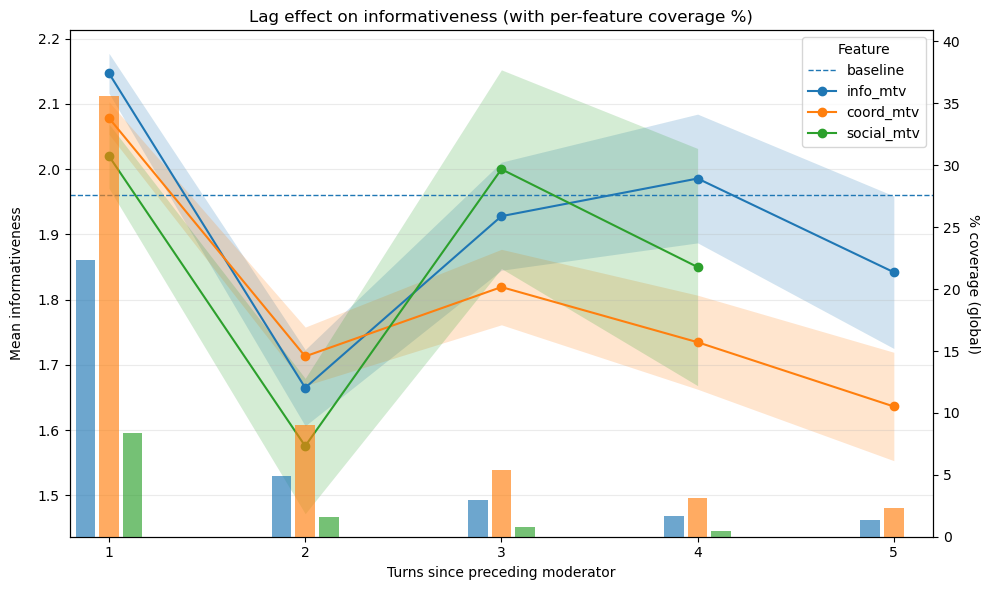

In [23]:
plot_lag_single_with_pct_breakdown(
    lag_tab,
    min_count=20,
    top_k=8,                   # show top 8 features by peak mean
    show_sem=True,
    annotate_n=False,
    baseline=baseline,
    x_ticks=(1,2,3,4,5),
    bar_width_feat=0.10,
    bar_gap=0.02
)

In [17]:
# lag_tab from your lag_ribbons_from_adj(...)
plot_lag_single_with_pct(
    lag_tab,
    min_count=20,
    top_k=8,
    show_sem=True,
    annotate_n=False,
    baseline=None,
    x_ticks=(1,2,3,4,5)
)


NameError: name 'lag_tab' is not defined

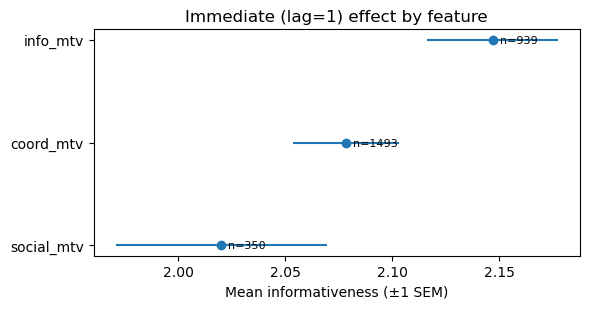

In [486]:
plot_lag1_forest(lag_tab, min_count=10)

In [487]:
part, adj_tab, baseline, lag_tab = show_moderator_act(df_all, "insq", acts=True, motives=False)
adj_tab

Overall participant informativeness mean: 1.961


,feature,count,mean,sem,lift_vs_overall,lift_vs_overall_marked,lift_vs_counterpart,lift_vs_counterpart_marked,p_value_counterpart
0,conf,616,2.121753,0.037328,0.160545,0.161*,0.199650,0.200*,0.000002
1,inst,1334,1.901799,0.025674,-0.059409,-0.059*,-0.103171,-0.103*,0.002238
2,intp,283,1.992933,0.053449,0.031725,0.032,0.034862,0.035,0.535844
3,prob,1206,2.058043,0.027159,0.096835,0.097*,0.157063,0.157*,0.000005
4,supp,260,1.923077,0.057218,-0.038131,-0.038,-0.041568,-0.042,0.487595
5,util,656,1.937500,0.035986,-0.023708,-0.024,-0.029957,-0.030,0.460818


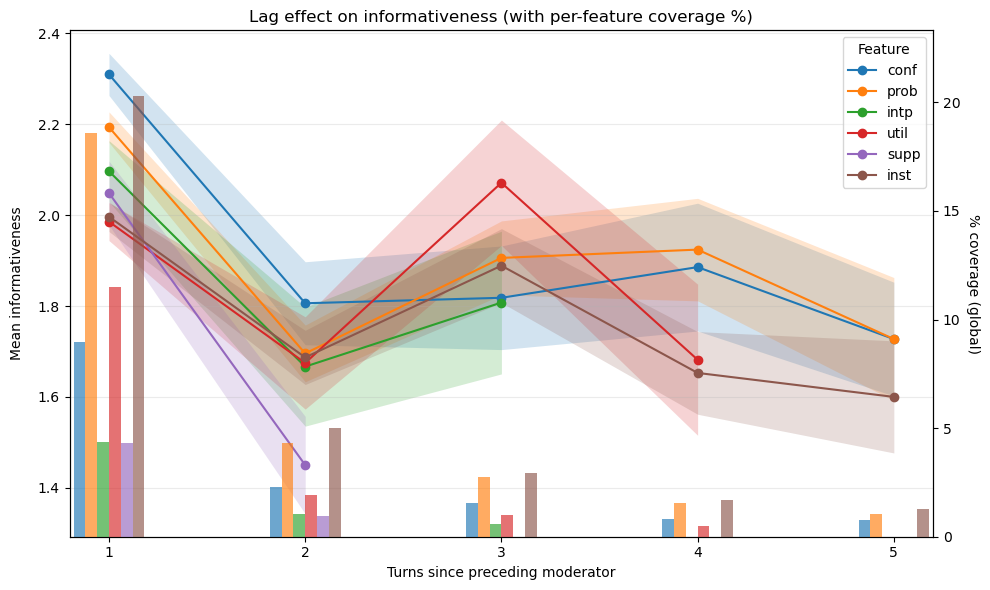

In [488]:
plot_lag_single_with_pct_breakdown(
    lag_tab,
    min_count=20,
    top_k=8,                   # show top 8 features by peak mean
    show_sem=True,
    annotate_n=False,
    baseline=None,
    x_ticks=(1,2,3,4,5),
    bar_width_feat=0.06,
    bar_gap=0.0
)

In [491]:
part, adj_tab, baseline, lag_tab = show_moderator_act(df_all, "fora", acts=False, motives=True)
adj_tab

Overall participant informativeness mean: 2.024


,feature,count,mean,sem,lift_vs_overall,lift_vs_overall_marked,lift_vs_counterpart,lift_vs_counterpart_marked,p_value_counterpart
0,coord_mtv,144,2.000000,0.078223,-0.023734,-0.024,-0.030738,-0.031,0.731372
1,info_mtv,503,2.047714,0.042162,0.023980,0.024,0.117481,0.117,0.221844
2,social_mtv,186,2.069892,0.072745,0.046158,0.046,0.065408,0.065,0.443145


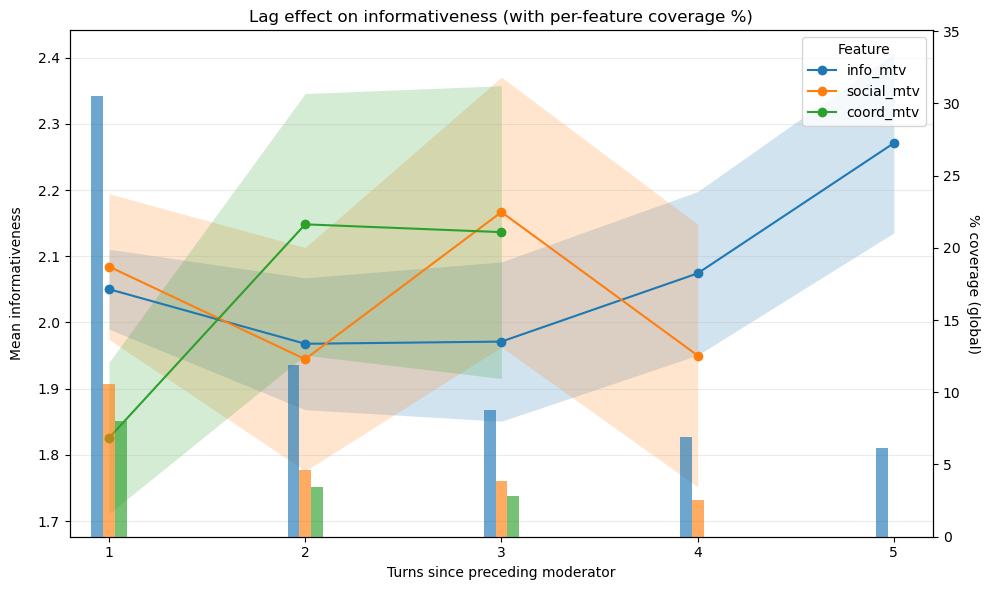

In [492]:
plot_lag_single_with_pct_breakdown(
    lag_tab,
    min_count=20,
    top_k=8,                   # show top 8 features by peak mean
    show_sem=True,
    annotate_n=False,
    baseline=None,
    x_ticks=(1,2,3,4,5),
    bar_width_feat=0.06,
    bar_gap=0.0
)

In [18]:
part, adj_tab, baseline, lag_tab = show_moderator_act(df_all, "fora", acts=True, motives=False)
adj_tab

NameError: name 'df_all' is not defined

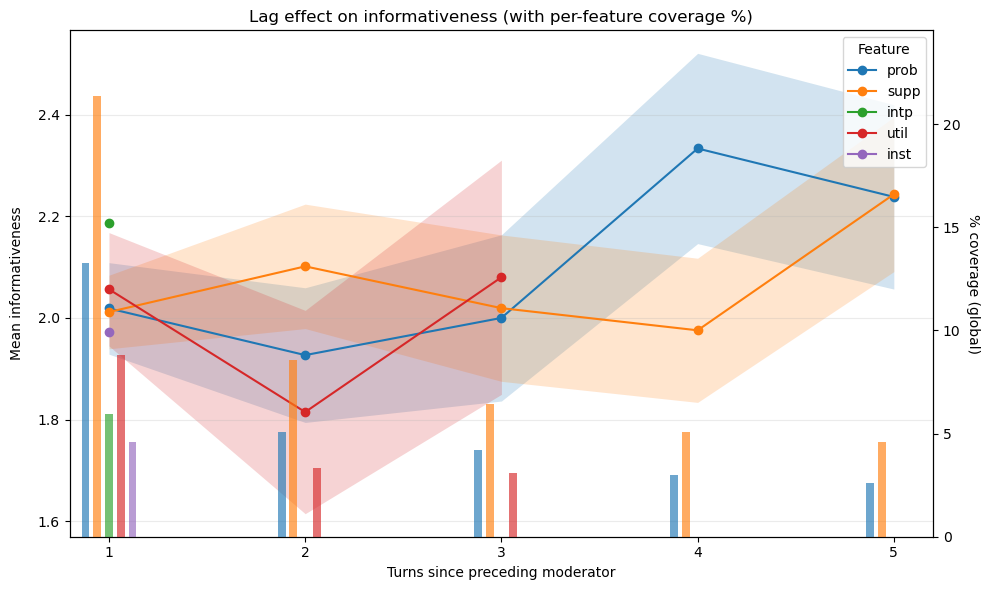

In [494]:
plot_lag_single_with_pct_breakdown(
    lag_tab,
    min_count=20,
    top_k=8,                   # show top 8 features by peak mean
    show_sem=True,
    annotate_n=False,
    baseline=None,
    x_ticks=(1,2,3,4,5),
    bar_width_feat=0.04,
    bar_gap=0.02
)